## Problem Statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [13]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
## Paths of train and test dataset on Google drive

data_dir_train = pathlib.Path("/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [16]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset
Define some parameters:

In [17]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [18]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [19]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [20]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

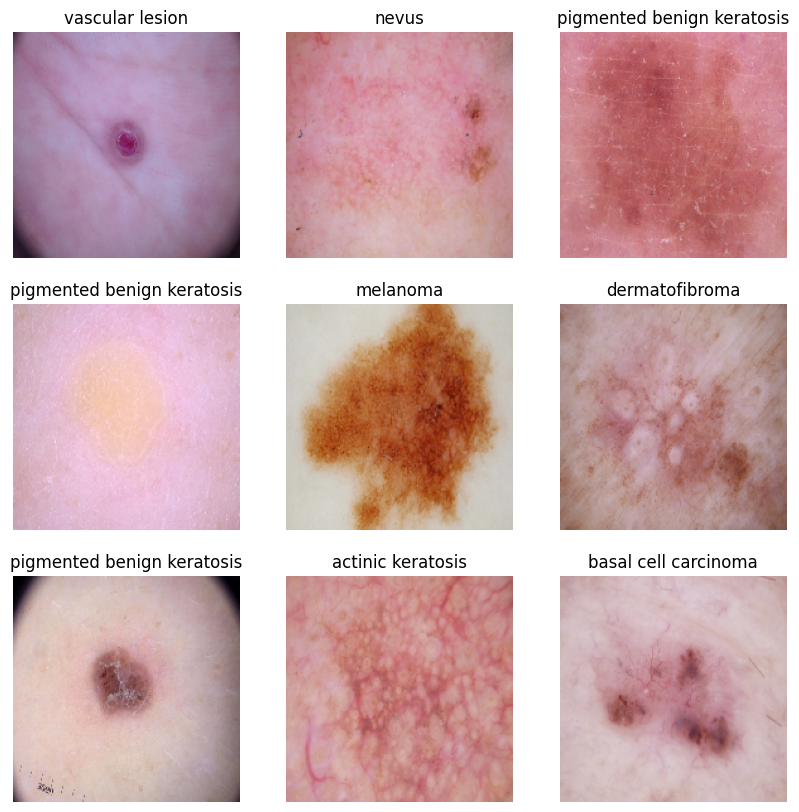

In [21]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
# Number of target labels are 9
target_labels = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [24]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [26]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.2204 - loss: 2.2451 - val_accuracy: 0.3803 - val_loss: 1.7425
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4082 - loss: 1.6541 - val_accuracy: 0.4944 - val_loss: 1.5521
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4874 - loss: 1.4723 - val_accuracy: 0.5481 - val_loss: 1.3996
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5285 - loss: 1.3284 - val_accuracy: 0.4855 - val_loss: 1.5473
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5527 - loss: 1.2722 - val_accuracy: 0.4922 - val_loss: 1.4674
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5838 - loss: 1.1726 - val_accuracy: 0.5570 - val_loss: 1.2767
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6186 - loss: 1.0636 - val_accuracy: 0.5459 - val_loss: 1.4024
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6405 - loss: 1.0037 - val_accuracy: 0.5570 - v

### Visualizing training results

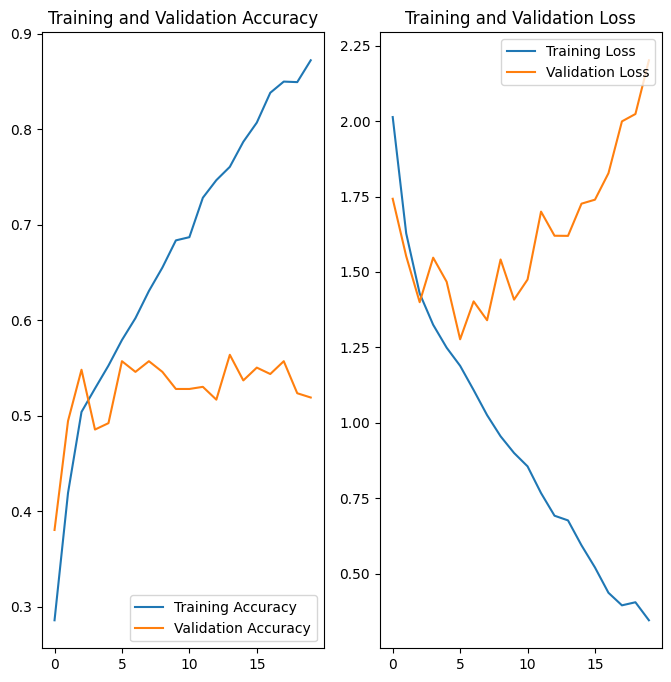

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***

1. The model's training accuracy shows a steady increase of upto 88%, while validation accuracy remains consistently around 52%.

2. These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.

In [29]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


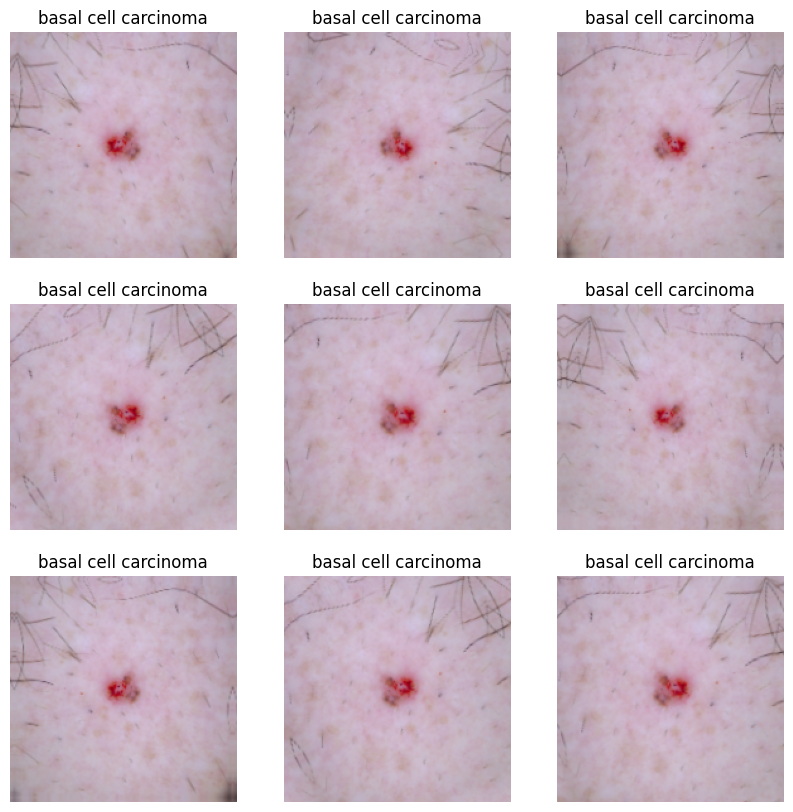

In [30]:
# Visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Create the model, compile and train the model


In [31]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### Compiling the model

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [33]:
%%time
## Train model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.2226 - loss: 2.0792 - val_accuracy: 0.3110 - val_loss: 1.7897
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3854 - loss: 1.6909 - val_accuracy: 0.4944 - val_loss: 1.5442
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4745 - loss: 1.4748 - val_accuracy: 0.5123 - val_loss: 1.3916
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5132 - loss: 1.3999 - val_accuracy: 0.4944 - val_loss: 1.4906
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5314 - loss: 1.3483 - val_accuracy: 0.5280 - val_loss: 1.4021
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5380 - loss: 1.3110 - val_accuracy: 0.5459 - val_loss: 1.3357
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5388 - loss: 1.2630 - val_accuracy: 0.5414 - val_loss: 1.3860
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5808 - loss: 1.2082 - val_accuracy: 0.5503 - v

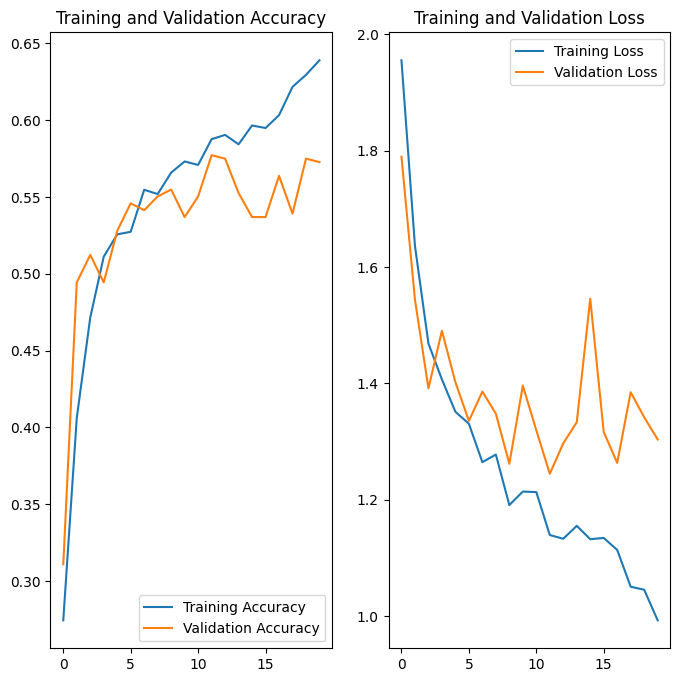

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***

1. By leveraging augmented data, overfitting has been effectively addressed.

2. The training and validation accuracy of the aforementioned model fall within a similar range.

3. Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.

#### Find the distribution of classes in the training dataset.
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [35]:
from glob import glob

images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [36]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024867.jpg', 'vascular lesion'), ('/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024706.jpg', 'vascular lesion'), ('/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0024747.jpg', 'vascular lesion'), ('/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0029889.jpg', 'vascular lesion'), ('/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0030070.jpg', 'vascular lesion')]


In [37]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
1,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
2,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
3,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
4,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion


In [38]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


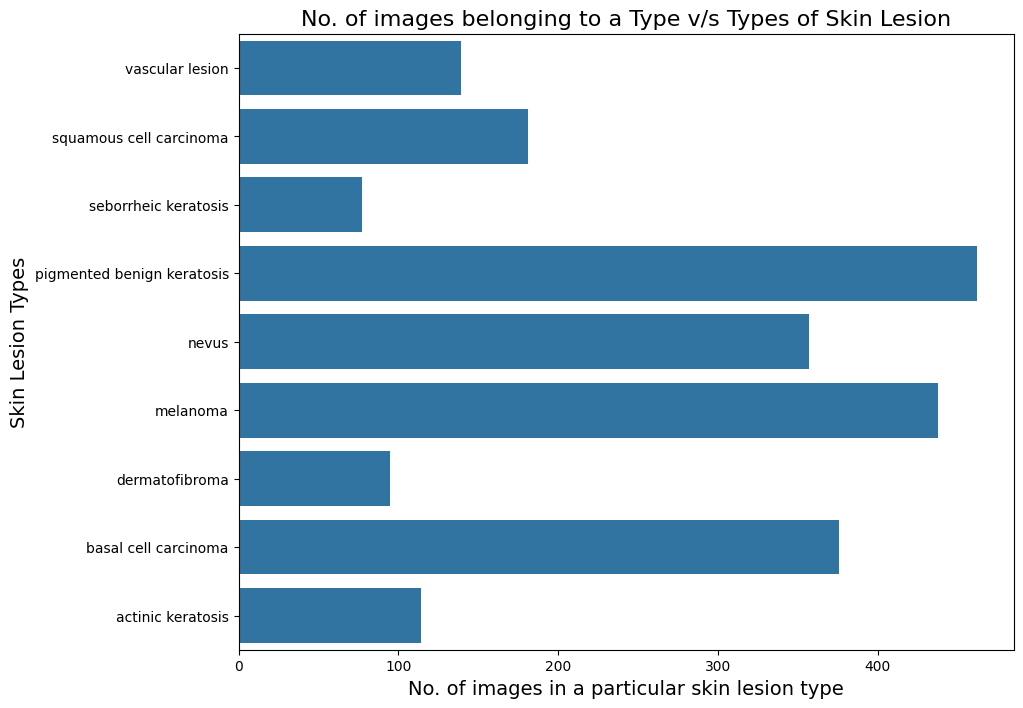

In [39]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [ ]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

***Observations:***

1. A clear class imbalance is evident within the training data.

2. The class **"seborrheic keratosis"** comprises the smallest proportion of samples, accounting for approximately **3.44%**.

3. **"Pigmented benign keratosis"** and **"melanoma"** significantly outweigh other classes, representing approximately **20.63%** and **19.56%** of the data, respectively.

#### Rectify the class imbalance


In [40]:
!pip install Augmentor

In [41]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79654B69C9D0>: 100%|██████████| 500/500 [00:26<00:00, 18.82 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796547CCB890>: 100%|██████████| 500/500 [00:17<00:00, 29.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79654B37E250>: 100%|██████████| 500/500 [00:17<00:00, 29.14 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79654B3B6E50>: 100%|██████████| 500/500 [01:30<00:00,  5.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x796547E8B390>: 100%|██████████| 500/500 [01:15<00:00,  6.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79654B35FE10>: 100%|██████████| 500/500 [00:17<00:00, 28.72 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x796547E7B510>: 100%|██████████| 500/500 [00:44<00:00, 11.11 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796547E5C090>: 100%|██████████| 500/500 [00:18<00:00, 26.55 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79654B3B4390>: 100%|██████████| 500/500 [00:17<00:00, 29.21 Samples/s]


##### Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [42]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033844.jpg_151519fb-e7db-4708-b535-c7d1e54019e3.jpg',
 '/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031346.jpg_25bbb13c-fb59-4219-bb7d-abeba27fe40a.jpg',
 '/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032557.jpg_6f5a99f3-0ac7-4dff-b7ed-ce2cb491abb2.jpg',
 '/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025677.jpg_cdf0a16c-c002-4f5a-b306-abd9a6b6c70e.jpg',
 '/content/drive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC

In [44]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion']

In [45]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [48]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

In [49]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
1,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
2,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
3,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion
4,/content/drive/My Drive/Melanoma Detection Ass...,vascular lesion


In [50]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


In [51]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,14.28
melanoma,13.92
basal cell carcinoma,13.00
nevus,12.72
squamous cell carcinoma,10.11
vascular lesion,9.48
actinic keratosis,9.11
dermatofibroma,8.83
seborrheic keratosis,8.56


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [52]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [53]:
# Training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (with Batch normalization)

In [55]:
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compile your model

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [57]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.2386 - loss: 3.4535 - val_accuracy: 0.1084 - val_loss: 42.1466
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 227ms/step - accuracy: 0.3586 - loss: 1.7557 - val_accuracy: 0.1975 - val_loss: 15.7600
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.4037 - loss: 1.6135 - val_accuracy: 0.3125 - val_loss: 3.6746
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.4278 - loss: 1.5431 - val_accuracy: 0.3697 - val_loss: 1.6094
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 243ms/step - accuracy: 0.4255 - loss: 1.4616 - val_accuracy: 0.3801 - val_loss: 1.6337
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 230ms/step - accuracy: 0.4422 - loss: 1.4098 - val_accuracy: 0.4068 - val_loss: 1.6890
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - accuracy: 0.4749 - loss: 1.3438 - val_accuracy: 0.4269 - val_loss: 1.4557
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.4797 - loss:

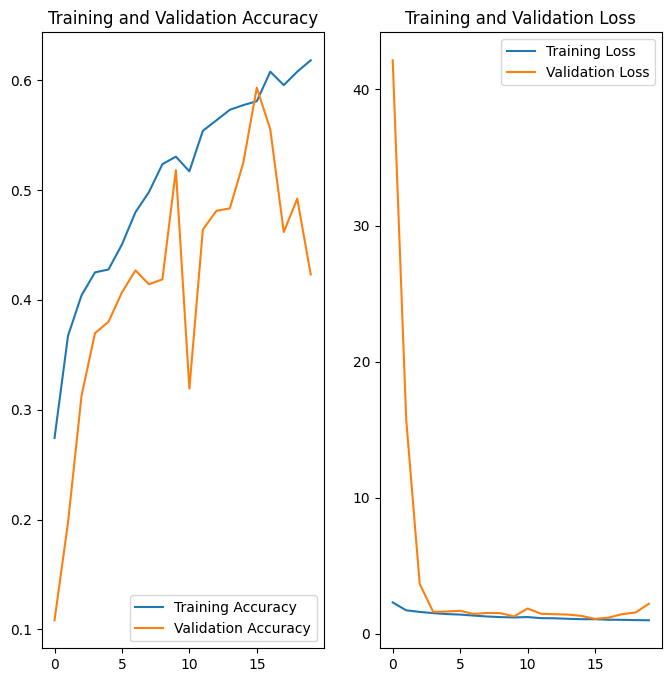

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***

1. Implementing batch normalization in the model yielded a slight uptick in both training and validation accuracy.
2. Formulating an alternative model without batch normalization aims to investigate prospective improvements in accuracy.

#### Creating another model (without batch normalization)

In [60]:
# create the model
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compiling the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

#### Training the model

In [62]:
%%time
# train the model
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.2373 - loss: 1.9996
Epoch 1: val_accuracy improved from -inf to 0.37120, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 247ms/step - accuracy: 0.2379 - loss: 1.9983 - val_accuracy: 0.3712 - val_loss: 1.6192
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4325 - loss: 1.4684
Epoch 2: val_accuracy improved from 0.37120 to 0.46919, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 226ms/step - accuracy: 0.4326 - loss: 1.4683 - val_accuracy: 0.4692 - val_loss: 1.4803
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4901 - loss: 1.3440
Epoch 3: val_accuracy improved from 0.46919 to 0.49146, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 222ms/step - accuracy: 0.4901 - loss: 1.3440 - val_accuracy: 0.4915 - val_loss: 1.3393
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5197 - loss: 1.2802
Epoch 4: val_accuracy improved from 0.4

#### Visualize the model results

In [63]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

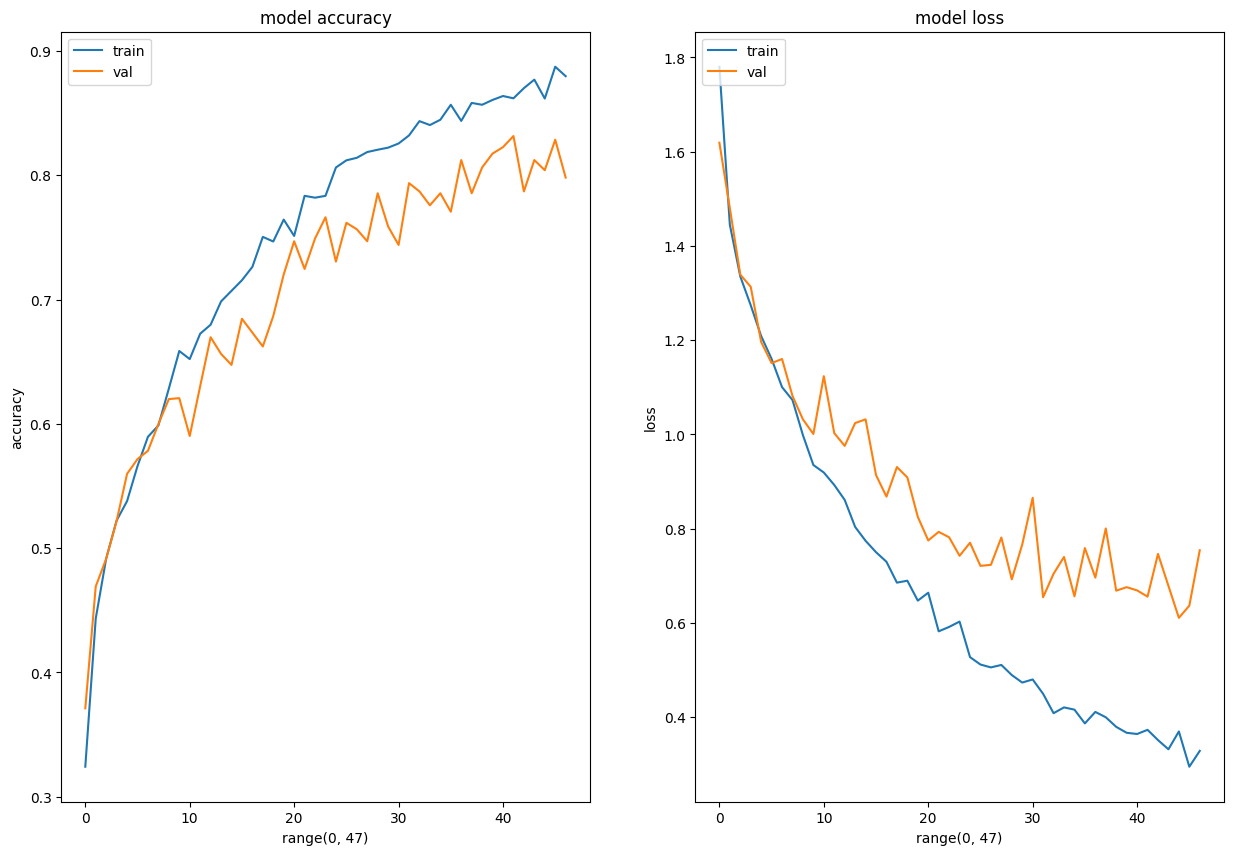

In [64]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

***Observations:***

1. The ultimate model showcases well-balanced performance, displaying no signs of underfitting or overfitting.

2. The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

3. Following 47 epochs, the final model attains an accuracy of 89% on the training set and approximately 80% on the validation set.

4. The addition of batch normalization failed to enhance both training and validation accuracy.

### Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


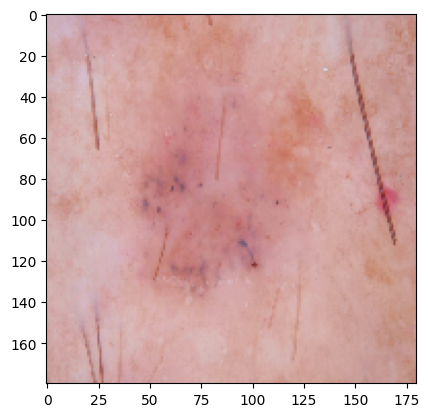

In [65]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)